In [14]:
%matplotlib inline
from sklearn.decomposition import PCA
import sys
sys.path.append("../")
import scvi
from scvi.dataset import CortexDataset, SmfishDataset
from scvi.inference import VariationalInferenceFish
from scvi.models import VAEF
from scvi.metrics.clustering import entropy_batch_mixing
from smFISH.metrics.visualisation import show_cell_types, show_mixing, compare_cell_types, show_gene_exp, show_spatial_expression
from scvi.metrics.classification import compute_accuracy_nn, compute_accuracy_svc
from scvi.metrics.imputation import proximity_imputation, plot_imputation
import numpy as np
from scvi.inference import adversarial_wrapper

# Creating and training the model

In [2]:
genes_to_discard = ['gad2', 'sox10']
gene_dataset_fish = SmfishDataset()
gene_names = gene_dataset_fish.gene_names
l = []
for n_gene in range(len(gene_names)):
    for gene in genes_to_discard:
        if gene_names[n_gene].lower() == gene.lower():
            l.append(n_gene)
genes_to_discard = l
indexes_to_keep = np.arange(len(gene_names))
indexes_to_keep = np.delete(indexes_to_keep, genes_to_discard)
# The "genes_to_discard" argument is given here so that the order of the genes in CortexDataset matches
# the order in SmfishDataset

File data/osmFISH_SScortex_mouse_all_cell.loom already downloaded
Preprocessing smFISH dataset
Finished preprocessing smFISH dataset


 We run with 50 additional genes for the scRNA-seq dataset

In [3]:
gene_dataset_seq = CortexDataset(genes_fish=gene_dataset_fish.gene_names, 
                                 genes_to_keep=["mog", "sst", "gja1", "ctss", "ndnf"], additional_genes=50)

File data/expression.bin already downloaded
Preprocessing Cortex data
Finished preprocessing Cortex data
7
['astrocytes_ependymal', 'endothelial-mural', 'interneurons', 'microglia', 'oligodendrocytes', 'pyramidalCA1', 'pyramidal-SS']


In [4]:
vae = VAEF(gene_dataset_seq.nb_genes, indexes_to_keep, n_layers_decoder=1, n_latent=8,
           n_layers=1, n_hidden=256, reconstruction_loss='nb', dropout_rate=0.3, n_labels=7, n_batch=2, model_library=False)
infer = VariationalInferenceFish(vae, gene_dataset_seq, gene_dataset_fish, train_size=0.9, verbose=True, frequency=5, weight_decay=0.30, n_epochs_even=1, n_epochs_kl=1000,
                                cl_ratio = 30, n_epochs_cl=150)
infer = adversarial_wrapper(infer, scale=50, mode="smFISH")
infer.train(n_epochs=150, lr=0.001)
data_loader_fish = infer.data_loaders['train_fish']
data_loader_seq = infer.data_loaders['train_seq']



EPOCH [0/150]: 
LL for train_seq is : 401.4712
LL for test_seq is : 400.2329
LL for train_fish is : 208.8334
LL for test_fish is : 224.2275

EPOCH [5/150]: 
LL for train_seq is : 238.0479
LL for test_seq is : 237.7276
LL for train_fish is : 110.3979
LL for test_fish is : 109.3970

EPOCH [10/150]: 
LL for train_seq is : 225.5623
LL for test_seq is : 222.7133
LL for train_fish is : 86.7834
LL for test_fish is : 85.8403

EPOCH [15/150]: 
LL for train_seq is : 212.2923
LL for test_seq is : 210.0343
LL for train_fish is : 82.7033
LL for test_fish is : 81.6843

EPOCH [20/150]: 
LL for train_seq is : 207.5849
LL for test_seq is : 205.8297
LL for train_fish is : 79.6800
LL for test_fish is : 79.0265

EPOCH [25/150]: 
LL for train_seq is : 202.2115
LL for test_seq is : 199.8964
LL for train_fish is : 79.1069
LL for test_fish is : 78.7425

EPOCH [30/150]: 
LL for train_seq is : 201.1195
LL for test_seq is : 198.3538
LL for train_fish is : 77.3068
LL for test_fish is : 77.0503

EPOCH [35/150]: 


In [7]:
import torch
def get_dataset_information(vae, data_loader, mode="scRNA"):
    """ Gives access to information about the data points in the data_loader,
        as well as on outputs of the model for those data points (latent embedding,
        expected_frequencies...)
    """
    to_get = {"latent": [], "batch_indices": [],
              "labels": [], "values": [], "expected_frequencies": [], "x_coord": [], "y_coord": []}
    vae.eval()
    for tensors in data_loader:
        if mode == "scRNA":
            sample_batch, local_l_mean, local_l_var, batch_index, label = tensors
            to_get["latent"] += [vae.sample_from_posterior_z(sample_batch, y=label)]
            to_get["expected_frequencies"] += [vae.get_sample_scale(sample_batch, batch_index=batch_index)]
        if mode == "smFISH":
            sample_batch, local_l_mean, local_l_var, batch_index, label, x_coord, y_coord = tensors
            to_get["x_coord"] += [x_coord]
            to_get["y_coord"] += [y_coord]
            to_get["latent"] += [vae.sample_from_posterior_z(sample_batch, y=label, mode=mode)]
            to_get["expected_frequencies"] += [vae.get_sample_scale(sample_batch, mode=mode, batch_index=batch_index)]
        to_get["batch_indices"] += [batch_index]
        to_get["labels"] += [label]
        to_get["values"] += [sample_batch]
    for key in to_get.keys():
        if len(to_get[key]) > 0:
            to_get[key] = np.array(torch.cat(to_get[key]))
    return to_get

In [8]:
data_loader_fish = infer.data_loaders['train_fish']
data_loader_seq = infer.data_loaders['train_seq']
# Getting data of interest
dic = get_dataset_information(vae, data_loader_seq, mode="scRNA")
latent_seq, labels_seq, expected_frequencies_seq, values_seq = dic["latent"], dic["labels"], dic["expected_frequencies"], dic["values"]
dic = get_dataset_information(vae, data_loader_fish, mode="smFISH")
latent_fish, labels_fish, expected_frequencies_fish, values_fish = dic["latent"], dic["labels"], dic["expected_frequencies"], dic["values"]
x_coord = dic["x_coord"]
y_coord = dic["y_coord"]

In [9]:
# Getting data for benchmark
concatenated_matrix = np.concatenate((gene_dataset_fish.X[:, vae.indexes_to_keep], gene_dataset_seq.X[:, vae.indexes_to_keep]))
concatenated_matrix = np.log(1 + concatenated_matrix)
PCA_labels = gene_dataset_fish.labels.ravel()
PCA_labels_reg = gene_dataset_seq.labels.ravel()
pca = PCA(n_components=9)
latent_pca = pca.fit_transform(concatenated_matrix)
PCA_latent_fish = latent_pca[:gene_dataset_fish.X.shape[0], :]
PCA_latent_seq = latent_pca[gene_dataset_fish.X.shape[0]:, :]
PCA_values_seq = gene_dataset_seq.X
PCA_values_fish = gene_dataset_fish.X
PCA_labels_seq = gene_dataset_seq.labels
PCA_labels_fish = gene_dataset_fish.labels

# 1. Imputation

In [10]:
def get_index(gene_names, gene):
    idx = 0
    for gene_cortex in range(len(gene_names)):
        if gene_names[gene_cortex].lower() == gene.lower():
            idx = gene_cortex
            print("Found idx " + str(idx) + " for gene " + gene + "!")
    return idx

idx_gad = get_index(gene_dataset_seq.gene_names, "gad2")
idx_sox = get_index(gene_dataset_seq.gene_names, "sox10")

Found idx 0 for gene gad2!
Found idx 17 for gene sox10!


## Imputing missing gene GAD2: our method vs baseline

In [11]:
def imputation_metrics(original, imputed):
    absolute_error = np.abs(original-imputed)
    relative_error = 0.5 * absolute_error / (1 + np.abs(original) + np.abs(imputed))
    return {"mean_absolute_error": np.mean(absolute_error), "median_absolute_error": np.median(absolute_error), 
            "mean_relative_error": np.mean(relative_error), "median_relative_error": np.median(relative_error)}   

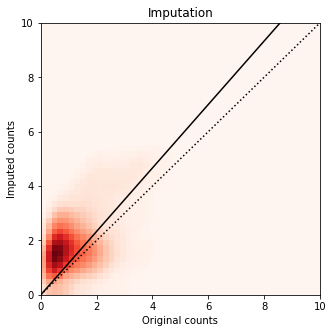

{'mean_absolute_error': 10.248663, 'median_absolute_error': 3.4575856, 'mean_relative_error': 0.23553284, 'median_relative_error': 0.24019492}


<Figure size 432x288 with 0 Axes>

In [16]:
imputed = expected_frequencies_fish[:, idx_gad] 
imputed = imputed / np.sum(expected_frequencies_fish[:, vae.indexes_to_keep], axis=1).ravel()
imputed *= np.sum(values_fish[:, vae.indexes_to_keep], axis=1)
plot_imputation(np.log(1+values_fish[:, idx_gad]), np.log(1+imputed))
print(imputation_metrics(values_fish[:, idx_gad], imputed))

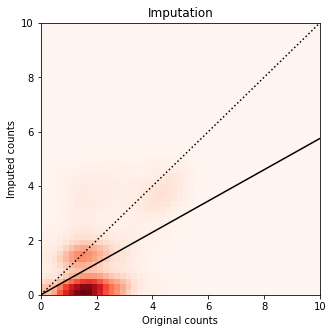

{'mean_absolute_error': 11.406786632330798, 'median_absolute_error': 4.0, 'mean_relative_error': 0.2823452834258376, 'median_relative_error': 0.3333333333333333}


<Figure size 432x288 with 0 Axes>

In [15]:
predicted_PCA = proximity_imputation(PCA_latent_seq, PCA_values_seq[:, idx_gad], PCA_latent_fish, k=5)
mean = np.mean(PCA_values_fish[:, idx_gad])
to_keep = [idx for idx in range(len(PCA_values_fish[:, idx_gad])) if PCA_values_fish[idx, 0]<mean]
plot_imputation(np.log(1+predicted_PCA), np.log(1+PCA_values_fish[:, idx_gad]))
print(imputation_metrics(PCA_values_fish[:, idx_gad], predicted_PCA))

## Imputing missing gene SOX10: our method vs baseline

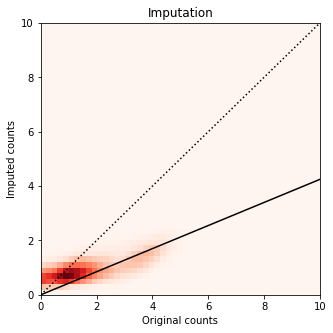

{'mean_absolute_error': 8.548558, 'median_absolute_error': 1.4138403, 'mean_relative_error': 0.21743543, 'median_relative_error': 0.20651962}


<Figure size 432x288 with 0 Axes>

In [17]:
imputed = expected_frequencies_fish[:, idx_sox] 
imputed = imputed / np.sum(expected_frequencies_fish[:, vae.indexes_to_keep], axis=1).ravel()
imputed *= np.sum(values_fish[:, vae.indexes_to_keep], axis=1)
mean = np.mean(values_fish[:, idx_sox])
plot_imputation(np.log(1+imputed), np.log(1+values_fish[:, idx_sox]))
print(imputation_metrics(values_fish[:, idx_sox], imputed))

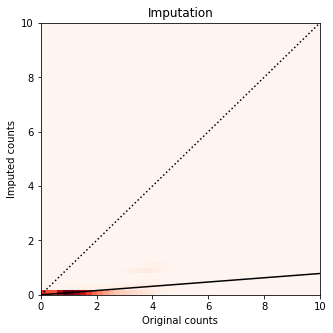

{'mean_absolute_error': 9.534563880062487, 'median_absolute_error': 2.0, 'mean_relative_error': 0.30823845335339084, 'median_relative_error': 0.3333333333333333}


<Figure size 432x288 with 0 Axes>

In [18]:
predicted_PCA = proximity_imputation(PCA_latent_seq, PCA_values_seq[:, idx_sox], PCA_latent_fish, k=5)
mean = np.mean(PCA_values_fish[:, idx_sox])
to_keep = [idx for idx in range(len(PCA_values_fish[:, idx_sox])) if PCA_values_fish[idx, idx_sox]<mean]
plot_imputation(np.log(1+predicted_PCA), np.log(1+PCA_values_fish[:, idx_sox]))
print(imputation_metrics(PCA_values_fish[:, idx_sox], predicted_PCA))

# 2. Getting a common meaningful representation

In [19]:
from sklearn.manifold import TSNE
def get_common_t_sne(latent_seq, latent_fish, n_samples=1000):
    idx_t_sne_a = np.random.permutation(len(latent_seq))[:n_samples]
    idx_t_sne_b = np.random.permutation(len(latent_fish))[:n_samples]
    full_latent = np.concatenate((latent_seq[idx_t_sne_a, :], latent_fish[idx_t_sne_b, :]))
    if full_latent.shape[1] != 2:
        latent = TSNE().fit_transform(full_latent)
    if latent.shape[0] != len(idx_t_sne_a) + len(idx_t_sne_b):
        print("Be careful! There might be a mistake in the downsampling of the data points")
    return latent[:len(idx_t_sne_a), :], latent[len(idx_t_sne_a):, :], idx_t_sne_a, idx_t_sne_b
t_sne_seq, t_sne_fish, idx_t_sne_seq, idx_t_sne_fish = get_common_t_sne(latent_seq, latent_fish, n_samples=1000)


## Our method: Embedding of the two datasets in the shared latent space

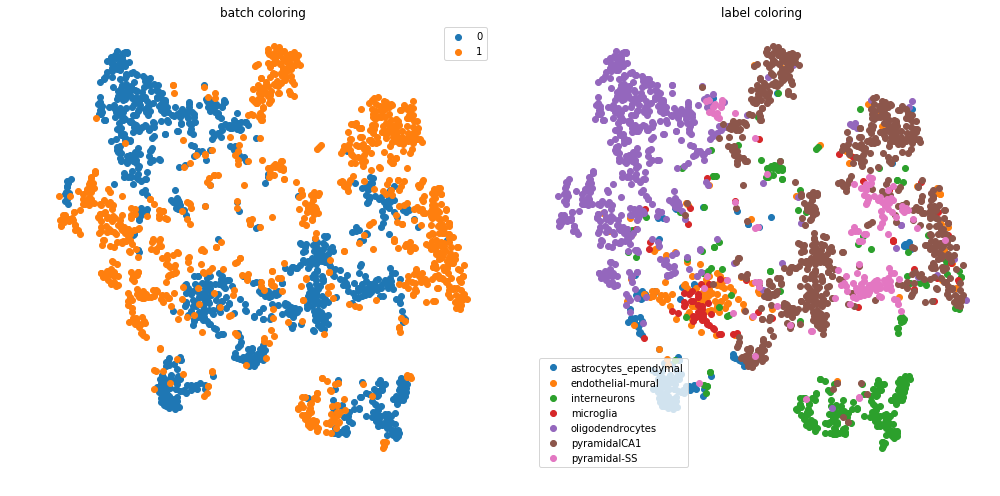

In [20]:
latent = np.concatenate((t_sne_seq, t_sne_fish), axis=0)
labels = np.concatenate((labels_seq[idx_t_sne_seq], labels_fish[idx_t_sne_fish]), axis=0)
batch_indices = np.concatenate((np.zeros_like(labels_seq[idx_t_sne_seq]), np.ones_like(labels_fish[idx_t_sne_fish])), axis=0)
infer.show_t_sne(None, color_by='batches and labels', latent=latent, labels =labels.ravel(), batch_indices = batch_indices.ravel(), n_batch=2)




## Benchmark: Embedding of the two datasets in the shared latent space

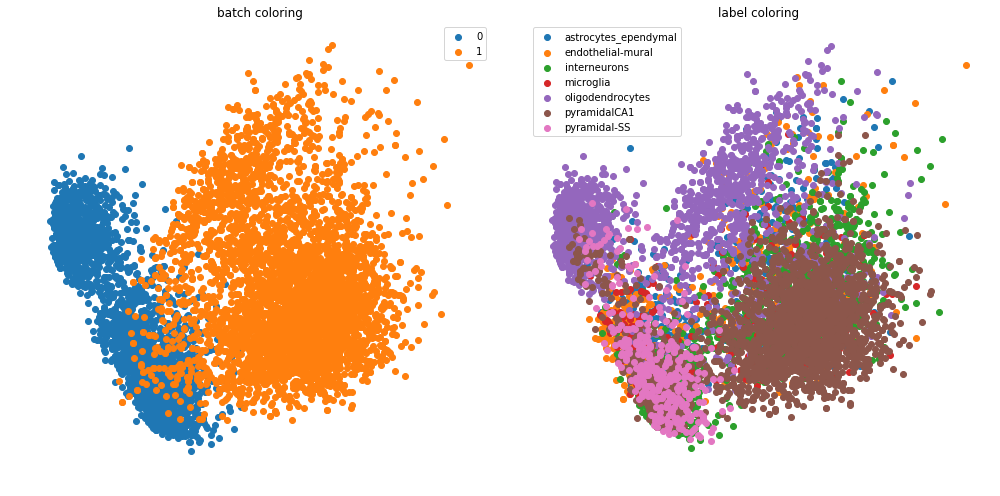

In [21]:
latent = np.concatenate((PCA_latent_seq[:, :2], PCA_latent_fish[:, :2]), axis=0)
labels = np.concatenate((PCA_labels_seq, PCA_labels_fish), axis=0)
batch_indices = np.concatenate((np.zeros_like(PCA_labels_seq), np.ones_like(PCA_labels_fish)), axis=0)
infer.show_t_sne(None, color_by='batches and labels', latent=latent, labels =labels.ravel(), batch_indices = batch_indices.ravel(), n_batch=2)

# show_cell_types(PCA_latent_seq[:, :2], PCA_labels_seq.ravel(), PCA_latent_fish[:, :2], PCA_labels_fish.ravel())


## Batch entropy: How well do the datasets mix in the latent space?

In [22]:
print(entropy_batch_mixing(np.concatenate((t_sne_seq, t_sne_fish)),
                           batches=np.concatenate((np.zeros_like(idx_t_sne_seq),
                                                  np.ones_like(idx_t_sne_fish)))))

0.49275829053741965


In [23]:
print(entropy_batch_mixing(np.concatenate((PCA_latent_seq[:, :2], PCA_latent_fish[:, :2])),
                           batches=np.concatenate((np.zeros_like(PCA_latent_seq[:, :2]),
                                                  np.ones_like(PCA_latent_fish[:, :2])))))

0.09858302703988675


## Is the data structure conserved in the latent space?

We plot the values of expected frequencies of marker genes for sub-cell types for scRNA-seq data. If cells with high values for those genes are grouped together, it means that the structure at the sub-cell-type scale is conserved within the latent space

In [24]:
idx_astro = get_index(gene_dataset_seq.gene_names, "gja1")
idx_oligo = get_index(gene_dataset_seq.gene_names, "mog")
idx_interneurons = get_index(gene_dataset_seq.gene_names, "sst")

Found idx 80 for gene gja1!
Found idx 66 for gene mog!
Found idx 37 for gene sst!


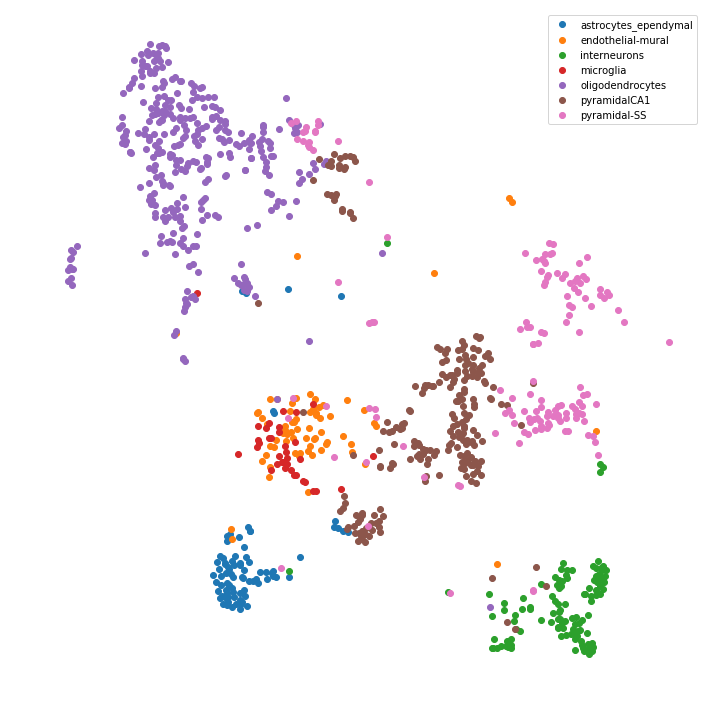

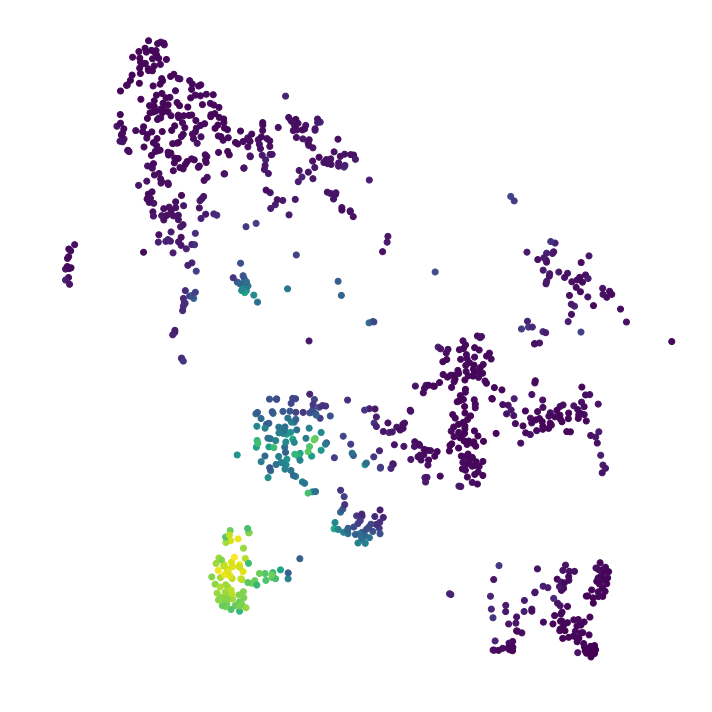

In [25]:
infer.show_t_sne(None, color_by='labels', latent=t_sne_seq, labels =labels_seq[idx_t_sne_seq].ravel())
infer.show_t_sne(None, color_by='scalar', save_name="", latent=t_sne_seq, batch_indices=None,
                        labels=expected_frequencies_seq[idx_t_sne_seq, idx_astro])

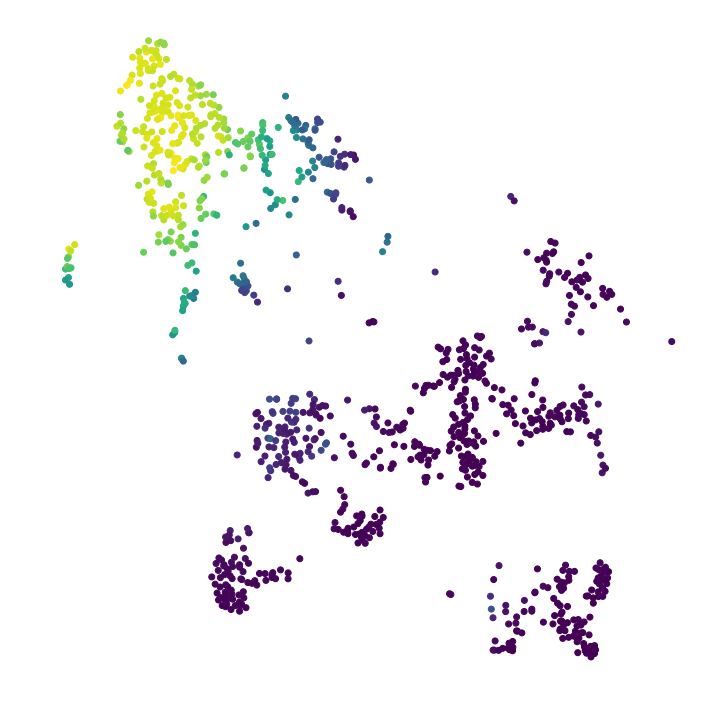

In [26]:
infer.show_t_sne(None, color_by='scalar', save_name="", latent=t_sne_seq, batch_indices=None,
                        labels=expected_frequencies_seq[idx_t_sne_seq, idx_oligo])

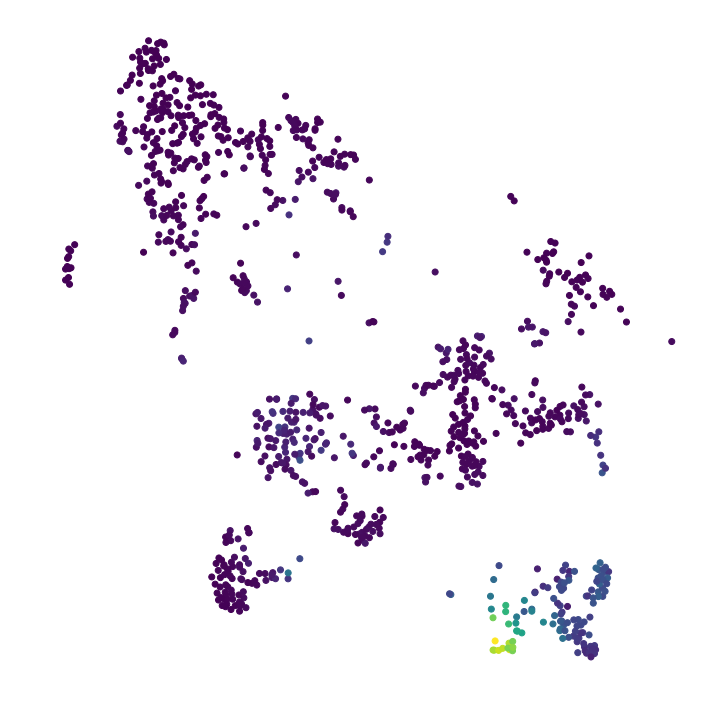

In [27]:
infer.show_t_sne(None, color_by='scalar', save_name="", latent=t_sne_seq, batch_indices=None,
                        labels=expected_frequencies_seq[idx_t_sne_seq, idx_interneurons])

# 3. Classifying cells in different cell types

In [28]:
from scvi.metrics.classification import compute_accuracy_svc, compute_accuracy_nn

In [29]:
# No distinction between pyramidal CA1 and pyramidal SS in the OsmFISH dataset
for label in range(len(labels_seq)):
    if labels_seq[label] == 6:
        labels_seq[label] = 5
for label in range(len(PCA_labels_seq)):
    if PCA_labels_seq[label] == 6:
        PCA_labels_seq[label] = 5
        
_, accuracy_svc, inferred_labels_svc = compute_accuracy_svc(expected_frequencies_seq, labels_seq.ravel(), expected_frequencies_fish, labels_fish.ravel(), return_labels=True)
_, PCA_accuracy, PCA_inferred_labels = compute_accuracy_nn(PCA_latent_seq, PCA_labels_seq.ravel(), PCA_latent_fish, PCA_labels_fish.ravel(), return_labels=True)


Accuracy and PCA_accuracy: KNN classifier based on our latent space and the baseline's latent space.                    
Accuracy_svc: obtained using a SVC classifier trained on the predicted expected frequencies for the counts 

In [30]:
print(PCA_accuracy)
print(accuracy_svc)

Accuracy(unweighted=0.6024204392649036, weighted=0.3912550555519309, worst=0.08045977011494253, accuracy_classes=[0.5871559633027523, 0.09342560553633218, 0.527599486521181, 0.08661417322834646, 0.08045977011494253, 0.9722753346080306])
Accuracy(unweighted=0.7011207970112079, weighted=0.45517528147821285, worst=0.043859649122807015, accuracy_classes=[0.425, 0.23484848484848486, 0.25685425685425683, 0.043859649122807015, 0.8296892980437284, 0.9408])


## Comparing inferred vs real labels: our method

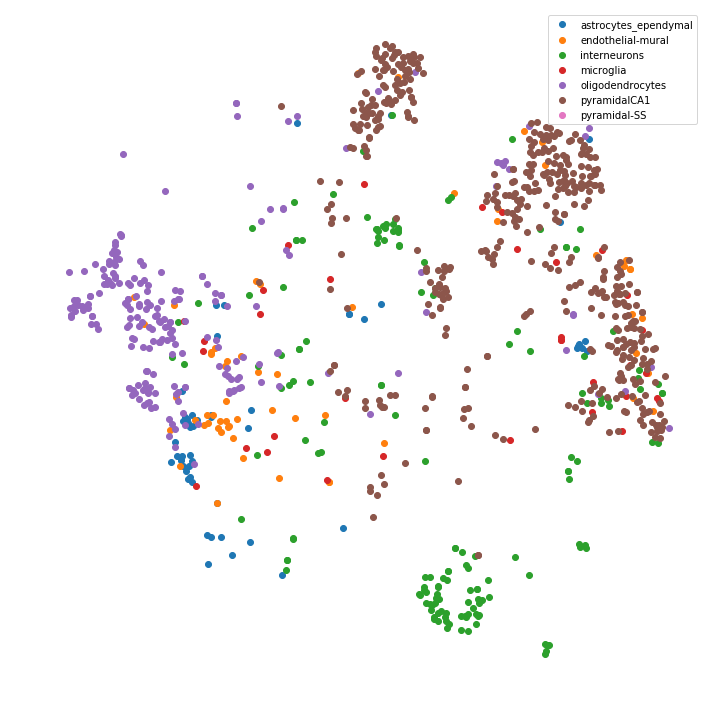

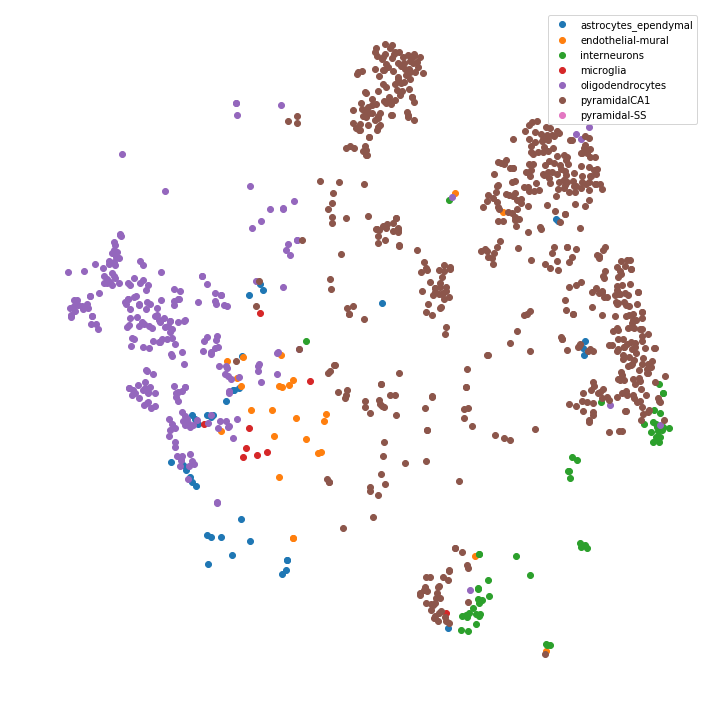

In [31]:
infer.show_t_sne(None, color_by='labels', latent=t_sne_fish, labels =labels_fish[idx_t_sne_fish].ravel())
infer.show_t_sne(None, color_by='labels', latent=t_sne_fish, labels =inferred_labels_svc[idx_t_sne_fish].ravel())

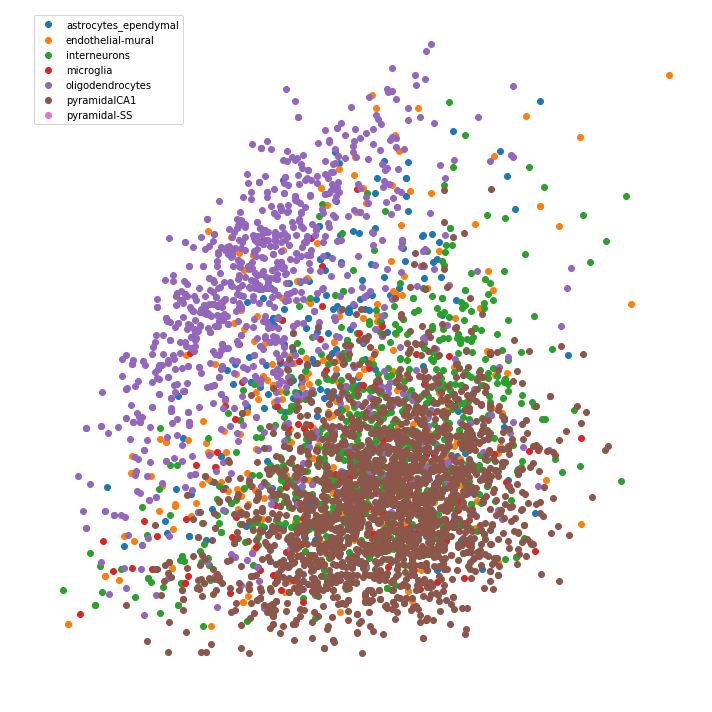

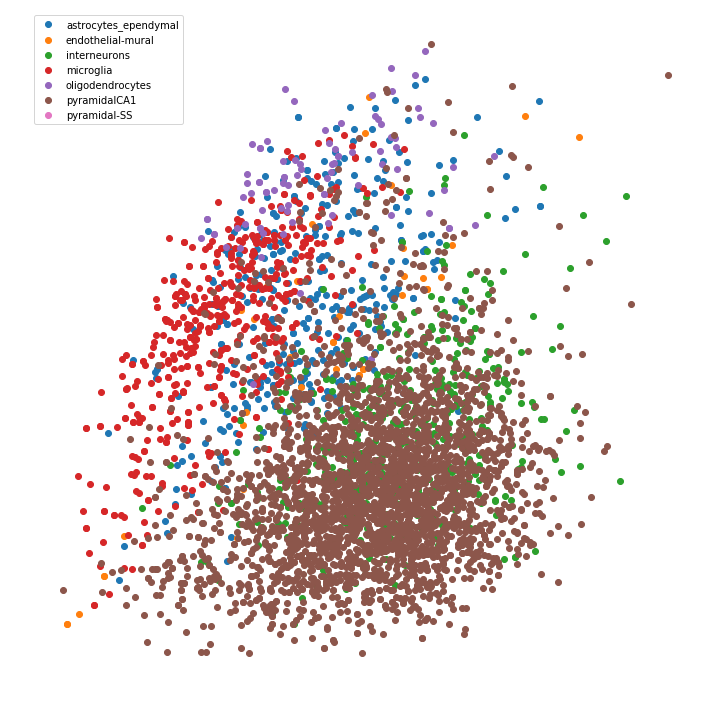

In [32]:
# compare_cell_types(PCA_latent_fish[:, :2], PCA_labels_fish.ravel(), PCA_inferred_labels)
infer.show_t_sne(None, color_by='labels', latent=PCA_latent_fish[:, :2], labels =PCA_labels_fish.ravel())
infer.show_t_sne(None, color_by='labels', latent=PCA_latent_fish[:, :2], labels = PCA_inferred_labels.ravel())

# 4. Going further: Imputing unobserved genes for the smFISH experiment

First, we impute marker genes for different cell types, to ensure the consistency of our model

## Astrocytes marker gene imputation

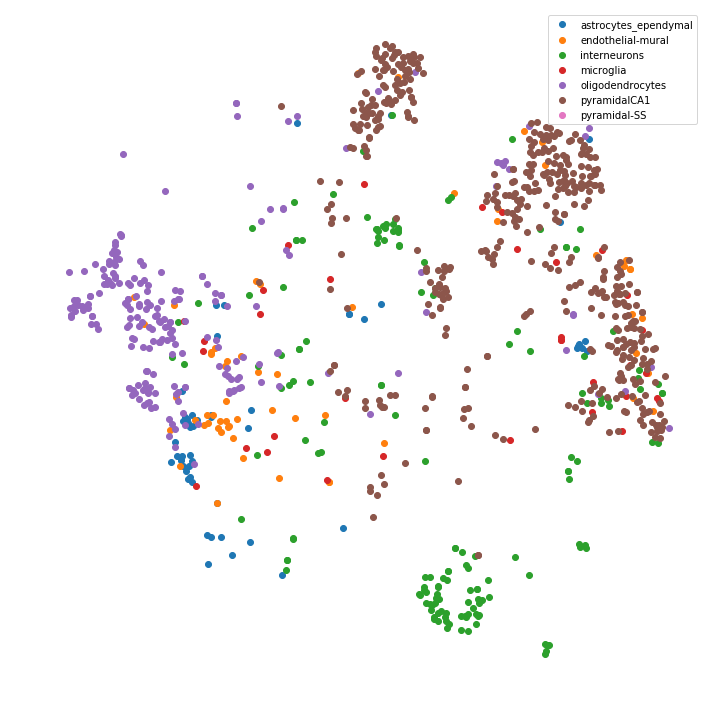

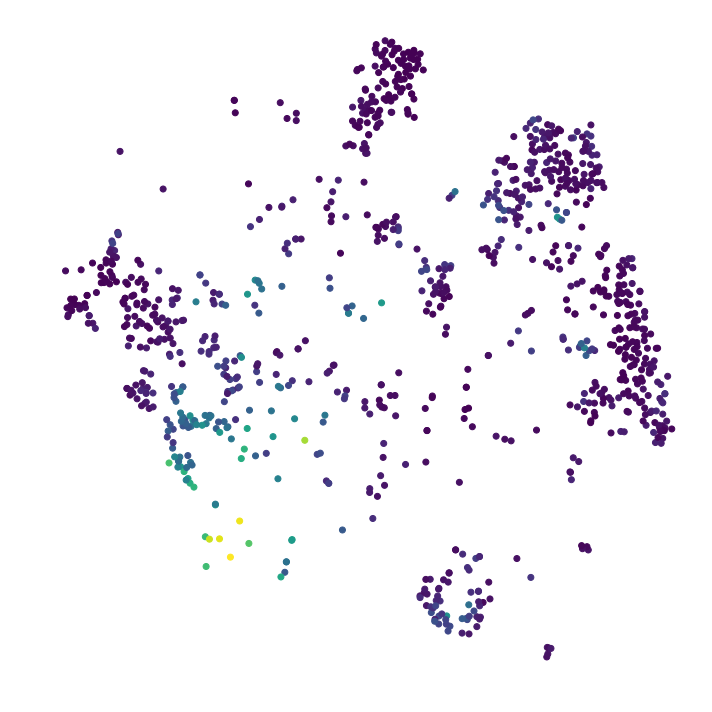

In [33]:
infer.show_t_sne(None, color_by='labels', latent=t_sne_fish, labels =labels_fish[idx_t_sne_fish].ravel())
infer.show_t_sne(None, color_by='scalar', save_name="", latent=t_sne_fish, batch_indices=None,
                        labels=expected_frequencies_fish[idx_t_sne_fish, idx_astro])

## Oligodendrocytes marker gene imputation
This marker gene defines a finer cell type within the astrocytes population. Here, we see a clear gradient of expression for this gene.   

Imputation of refined cell types marker gene is a feature that could help us get a more precise spatial map of cell types 

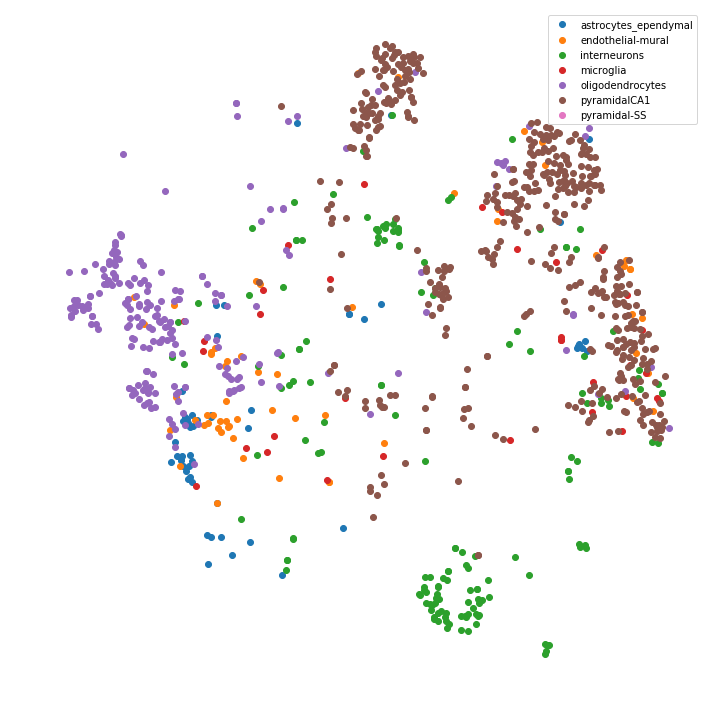

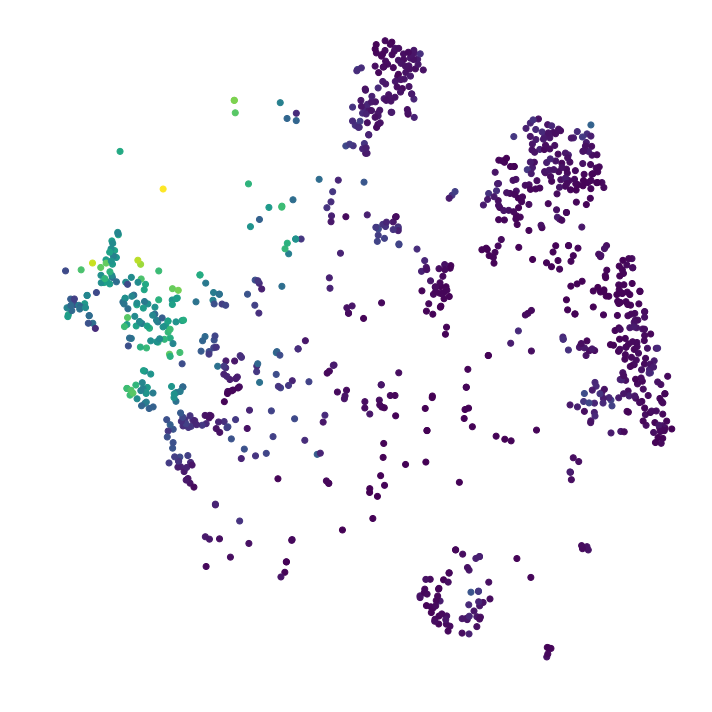

In [34]:
infer.show_t_sne(None, color_by='labels', latent=t_sne_fish, labels =labels_fish[idx_t_sne_fish].ravel())
infer.show_t_sne(None, color_by='scalar', save_name="", latent=t_sne_fish, batch_indices=None,
                        labels=expected_frequencies_fish[idx_t_sne_fish, idx_oligo])

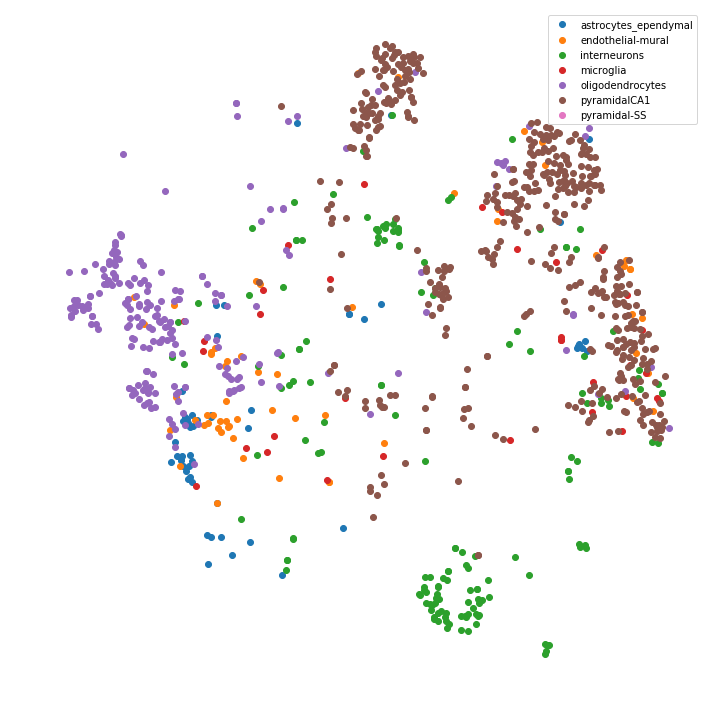

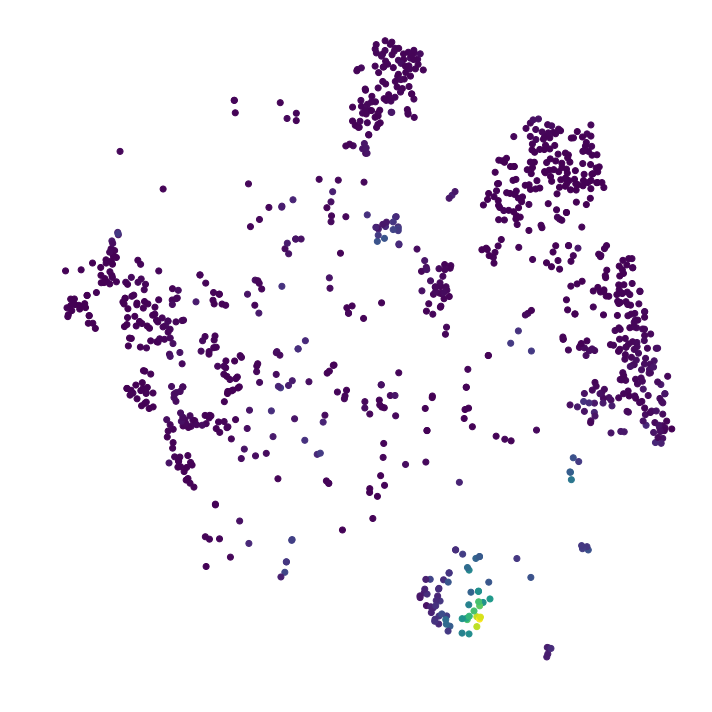

In [35]:
infer.show_t_sne(None, color_by='labels', latent=t_sne_fish, labels =labels_fish[idx_t_sne_fish].ravel())
infer.show_t_sne(None, color_by='scalar', save_name="", latent=t_sne_fish, batch_indices=None,
                        labels=expected_frequencies_fish[idx_t_sne_fish, idx_interneurons])

## Spatial imputation

Now that we can impute values for smFISH cells, we can estimate a spatial map for the gene expression of genes sequenced with scRNA-seq

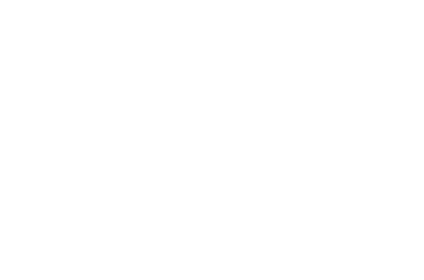

In [36]:
infer.show_spatial_expression(x_coord, y_coord,
                        labels_fish, color_by='label',
                        title="")

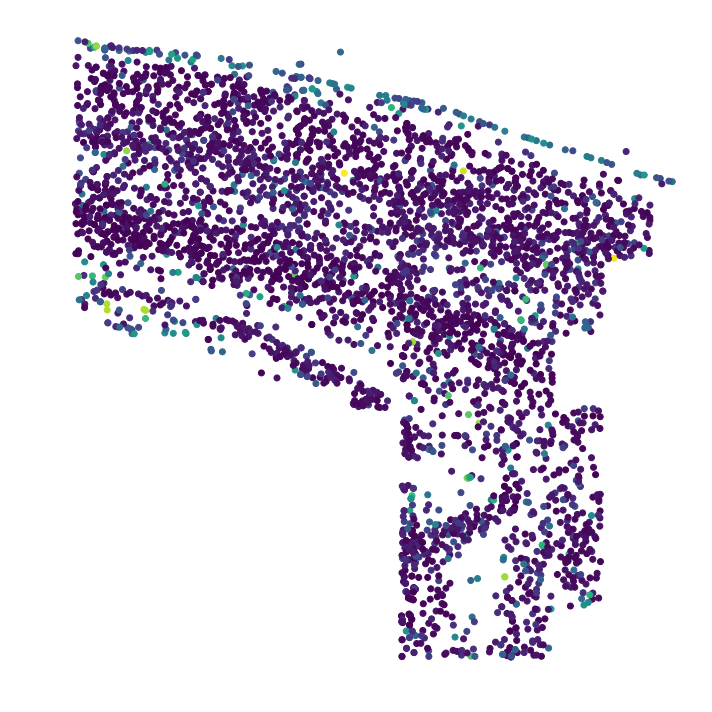

In [37]:
infer.show_spatial_expression(x_coord, y_coord,
                        expected_frequencies_fish[:, idx_astro],
                        title="")

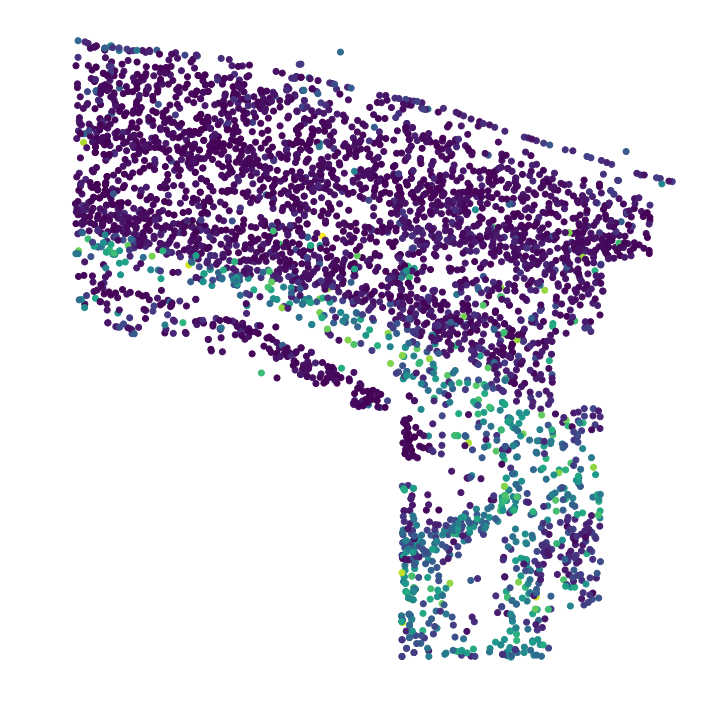

In [38]:
infer.show_spatial_expression(x_coord, y_coord,
                        expected_frequencies_fish[:, idx_oligo],
                        title="")

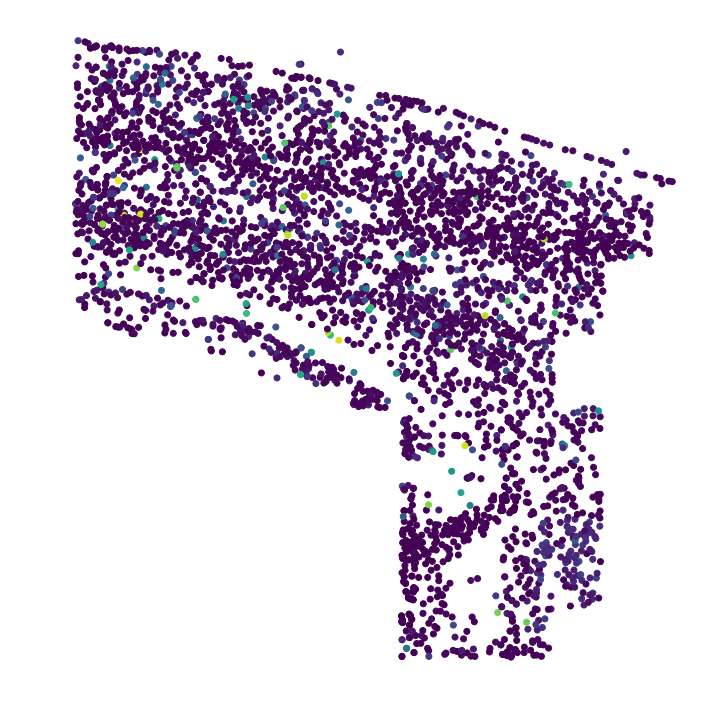

In [39]:
infer.show_spatial_expression(x_coord, y_coord,
                        expected_frequencies_fish[:, idx_interneurons],
                        title="")

## Finding spatially differentialy expressed genes

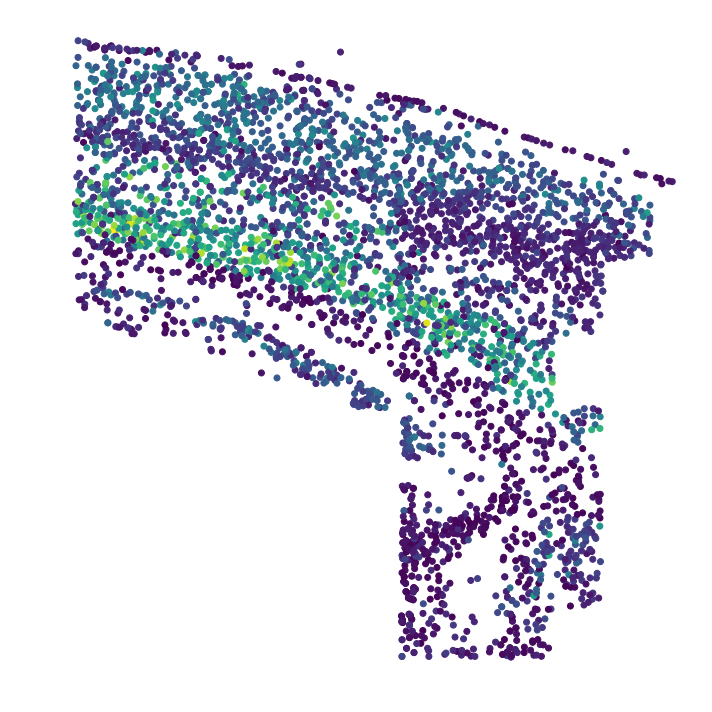

In [40]:
infer.show_spatial_expression(x_coord, y_coord,
                        expected_frequencies_fish[:, 45],
                        title="")